This tutorial demostrates Pointer Networks with readable code.

In [110]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

USE_CUDA = False

In [111]:
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Generating dataset for sorting task</h3>

In [112]:
class SortDataset(Dataset):
    
    def __init__(self, data_len, num_samples, random_seed=111):
        super(SortDataset, self).__init__()
        torch.manual_seed(random_seed)

        self.data_set = []
        for _ in tqdm(range(num_samples)):
            x = x = torch.randperm(data_len)
            # x = x = torch.ones(data_len, dtype=torch.int64) # a modification to understand embedding and encoder
            self.data_set.append(x)

        self.size = len(self.data_set)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.data_set[idx]

In [113]:
train_size = 5000
val_size = 500

In [114]:
train_dataset = SortDataset(10, train_size)
val_dataset   = SortDataset(10, val_size)

100%|██████████| 500/500 [00:00<00:00, 83342.69it/s]


In [115]:
j = 0
for i in train_dataset:
    print(i)
    j += 1
    if j == 5:
        break

tensor([0, 2, 6, 1, 8, 7, 5, 4, 3, 9])
tensor([4, 1, 9, 5, 2, 0, 8, 6, 7, 3])
tensor([6, 1, 8, 7, 9, 0, 5, 2, 3, 4])
tensor([6, 4, 0, 7, 5, 1, 9, 2, 8, 3])
tensor([5, 7, 0, 6, 4, 3, 1, 8, 9, 2])


<h3>Attention mechanism</h3>
<p>
Using two types of attention mechanism: "Dot" and "Bahdanau" . More details in <a href="http://aclweb.org/anthology/D15-1166">Effective Approaches to Attention-based Neural Machine Translation</a></p>

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & Dot \\
v_a ^\top \tanh(\textbf{W}_a [ h_t ; \bar h_s ]) & Bahdanau
\end{cases}
$$

<h3>Pointer Network</h3>
<p><a href="https://arxiv.org/abs/1506.03134">Pointer Networks
</a></p>
<p>The model solves the problem of variable size output dictionaries using a recently proposed mechanism of neural attention. It differs from the previous attention attempts in that, instead of using attention to blend hidden units of an encoder to a context vector at each decoder step, it uses attention as a pointer to select a member of the input sequence as the output.</p>
<img src="./imgs/Снимок экрана 2017-12-26 в 4.30.58 ДП.png">

In [116]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=True)

<h3>The data</h3>

In [117]:
for sample_batch in train_loader:
    inputs = Variable(sample_batch)
    print(inputs)
    print(sample_batch)
    print(torch.equal(sample_batch, inputs)) # True
    target = Variable(torch.sort(sample_batch)[1])
    print(torch.sort(sample_batch)) # returns: torch.return_types.sort( values=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]), indices=tensor([[5, 0, 9, 2, 3, 1, 8, 4, 7, 6]]) )
    print(target[ : , 0 : 5]) # sorted data
    break

tensor([[7, 1, 4, 9, 5, 3, 0, 6, 2, 8],
        [6, 5, 9, 7, 8, 3, 2, 4, 0, 1]])
tensor([[7, 1, 4, 9, 5, 3, 0, 6, 2, 8],
        [6, 5, 9, 7, 8, 3, 2, 4, 0, 1]])
True
torch.return_types.sort(
values=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
indices=tensor([[6, 1, 8, 5, 2, 4, 7, 0, 9, 3],
        [8, 9, 6, 5, 7, 1, 0, 3, 4, 2]]))
tensor([[6, 1, 8, 5, 2],
        [8, 9, 6, 5, 7]])


In [118]:
# example lstm run:
input = torch.tensor([
  [[0.11, 0.12], [0.13, 0.14], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]],
  [[0.13, 0.14], [0.15, 0.16], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]]
]) # shape - batch_size, embedding_size
print(input.shape)
"""
nn.LSTM(
  input_size: number of expected features in the input x, will be passed the embbed data, so it will have embedding_size,
  hidden_size: the number of features in the hidden state, in this case will have two features in the hidden state,
  batch_first: If True, then the input and output tensors are provided as (batch, seq_length, feature) instead of (seq, batch, feature)
)
 """
rnn = nn.LSTM(2, 2, batch_first=True)
h0 = torch.randn(1, 2, 2)
c0 = torch.randn(1, 2, 2)

"""
input = (batch_size, sequence_length, input_size) when batch_first=True
(h_0, c_0), **default hidden state and cell state to zeros if not provided (to encoder it's not provided, but for decoder is)**
h_0 = (D * num_layers, batch_size, hidden_size)
h_0 = (D * num_layers, batch_size, hidden_size)
"""
output, (hn, cn) = rnn(input, (h0, c0))
print('output:')
print(output)
print('hidden state output - ', hn)
print('hidden.squeeze(0) -', hn.squeeze(0))
print('cell state output - ', cn)

torch.Size([2, 10, 2])
output:
tensor([[[ 0.0325,  0.0415],
         [-0.0354,  0.0006],
         [-0.0822, -0.0137],
         [-0.1057, -0.0186],
         [-0.1176, -0.0185],
         [-0.1234, -0.0158],
         [-0.1260, -0.0146],
         [-0.1272, -0.0142],
         [-0.1279, -0.0140],
         [-0.1282, -0.0139]],

        [[-0.1647, -0.1687],
         [-0.2018, -0.0867],
         [-0.1705, -0.0584],
         [-0.1549, -0.0411],
         [-0.1449, -0.0300],
         [-0.1385, -0.0217],
         [-0.1342, -0.0177],
         [-0.1318, -0.0158],
         [-0.1304, -0.0149],
         [-0.1296, -0.0144]]], grad_fn=<TransposeBackward0>)
hidden state output -  tensor([[[-0.1282, -0.0139],
         [-0.1296, -0.0144]]], grad_fn=<StackBackward0>)
hidden.squeeze(0) - tensor([[-0.1282, -0.0139],
        [-0.1296, -0.0144]], grad_fn=<SqueezeBackward1>)
cell state output -  tensor([[[-0.4834, -0.0282],
         [-0.4895, -0.0291]]], grad_fn=<StackBackward0>)


<h3>What a forwad step does:</h3>


<img src='./.github/lstmcell.png' width='800px'>

<small>Image by The A.I. Hacker - Michael Phi - https://www.youtube.com/watch?v=8HyCNIVRbSU</small>

<p>blue activation is tanh, red is sigmoid</p>
<p>X is pointwise multiplication, + is pointwise addition</p>

In [119]:
# INIT VARIABLES

seq_len = 10
embedding_size = 3
hidden_size = 3

batch_size = 2

embedding = nn.Embedding(seq_len, embedding_size)
encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)

n_glimpses = 1
# tanh_exploration=10 # 10 or seq len, because seq_len is 10
tanh_exploration=5 # 10 or seq len, because seq_len is 10

print('Outside loop of train_loader, decoder_start_input: ')
decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
print(decoder_start_input.shape)
print(decoder_start_input)
# I believe decoder_start_input got started with random parameters
decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
# then decoder_start_input only gets regulated, by using uniform_, 
# passing -1 * 1. / math.sqrt(embedding_size) and 1. / math.sqrt(embedding_size) as arguments
print(decoder_start_input.shape)
print(decoder_start_input)

Outside loop of train_loader, decoder_start_input: 
torch.Size([3])
Parameter containing:
tensor([ 0.0000, 18.9802,  0.0000], requires_grad=True)
torch.Size([3])
Parameter containing:
tensor([ 0.5426,  0.3325, -0.3367], requires_grad=True)


In [120]:
# for sample_batch in train_loader:
it = iter(train_loader)
sample_batch = next(it)
print('train_loader loop started')
inputs = sample_batch
target = (torch.sort(sample_batch)[1])[ : , 0 : 5]
print('Input and target:')
print(inputs)
print(target)

batch_size = inputs.size(0) 
print('batch_size - ', batch_size) # returns 1, the batch_size example
seq_len = inputs.size(1)
print('seq_len - ', seq_len) # returns 10, the input number of entries/shape example, and ensures it's ten

embedded = embedding(inputs) # embedding take seq_len (10) and embedding_size (2) as arguments
print('embedded data:')
print(embedded.shape)
print(embedded)
"""
in this cell example, the embedding_size is 2, thus shape will output [1, 10, 2]
embedding can be thought as a manner of representing data, for example:
for an array like [1, 2, 3], we could say that the numbers could be represented by a vector of dimension two,
and the '1' being the value "[0.5, 0.6]" for example, the others will be represented by a vector as well
turning into [[0.4, 0.5], [0,6, 0,7], [0,8, 0.9]], for example.
Embed means implant, i.e. implant [0.4, 0.5] in 1.

This can verifired passing a [1, 1, 1, 1, ..., 1] (ten ones), 
all of them in a run got the following embedded result (the batch_size was 1):
tensor([[[-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391],
        [-0.5146, -0.6391]]], grad_fn=<EmbeddingBackward0>)
thus, '1' is [-0.5146, -0.6391]
"""
target_embedded = embedding(target) # also embbed the target
print('target_embedded shape - ', target_embedded.shape) # clearly, also returns shape [1, 10, 2]

train_loader loop started
Input and target:
tensor([[8, 9, 6, 5, 3, 7, 4, 1, 0, 2],
        [6, 1, 0, 4, 8, 3, 7, 5, 2, 9]])
tensor([[8, 7, 9, 4, 6],
        [2, 1, 8, 5, 3]])
batch_size -  2
seq_len -  10
embedded data:
torch.Size([2, 10, 3])
tensor([[[ 0.6224, -0.3131,  0.4891],
         [-0.4073,  0.5406, -0.2587],
         [ 0.9649, -0.1807, -0.4685],
         [ 0.9938, -0.6009,  0.4913],
         [-0.4216,  1.8703, -0.5444],
         [-0.0597,  0.2775, -1.6896],
         [-0.1916, -0.7063,  0.4785],
         [-1.2091,  0.1437, -1.8334],
         [ 0.6731,  0.7558, -0.1293],
         [ 1.0382,  0.9195, -1.0058]],

        [[ 0.9649, -0.1807, -0.4685],
         [-1.2091,  0.1437, -1.8334],
         [ 0.6731,  0.7558, -0.1293],
         [-0.1916, -0.7063,  0.4785],
         [ 0.6224, -0.3131,  0.4891],
         [-0.4216,  1.8703, -0.5444],
         [-0.0597,  0.2775, -1.6896],
         [ 0.9938, -0.6009,  0.4913],
         [ 1.0382,  0.9195, -1.0058],
         [-0.4073,  0.5406, -0.2

In [121]:
# encoder take embedding_size (2) and hidden_size (2) as arguments
encoder_outputs, (hidden, context) = encoder(embedded) 
"""
unlike embedding, enconder it's not just a way of representing data, since even passing a embbeded data
of only ones, it will not return all of them represetend by the same numbers

the hidden data is equals to the last sequence in encoder_outputs (tenth position)

notations from https://www.youtube.com/watch?v=8HyCNIVRbSU:
a RNN cell when processing passes the previous hidden state (output)
as input to the next step of the sequence (RNN cell), it will produce a hidden state as well
RNN cell receives as input the previous hidden state (output by the previous RNN cell) and
input, combines them to form a vector (this vector has info of current inputs and previous inputs),
the vector goes to tanh activation and the output is the new hidden state or the short-memory of the network
tanh makes a boundary between -1 and 1

LSTM also propagates information forward, the difference are in the operations done in a LSTM cell
able to forget or keep information, through gates in the cell, it uses sigmoid activation since
it squishes the values between 0 and 1, and a number times 0 is 0 (helping the to forget info
as well as multiplying by 1 keept the value):

forward step in a LSTM cell:
"t" means in a iterativa way, t is current iteration, t-1 is the previous.

1 - previous hidden state output and inputs gets combined and passed to the forget gate (sigmoid)
2 - passes the combined data to input gate, first to sigmoid (which values will be updated) and after to 
tanh function to squish values between -1 and 1 to regulate the network, then multiply the tanh output with 
the sigmoid output (sigmoid decides which information is important to keep from tanh output)
3 - calculate the cell state, first the previous cell state is multiplied by the forget vector (output from forget gate)
then do a pointwise addition between the cell state and the output from input gate (output from step 2)
i.e.e new cell state (Ct) = forgetgate * Ct-1 + input gate(sigmoid)(it) * input gate(tanh)(!ct)
4 - output gate, first passes the combined data into a sigmoid function, then the new cell state to a tanh function
multiply the sigmoid and tanh output, this will the new hidden state (lstm hidden state output)
5 - the new cell state and the new hidden state is carried to the next step (LSTM cell stacked)

forward step in a LSTM cell in code:
combine = prev_hidden_state + input # concatenate both
ft = forget_layer(combine) # forget gate
candidate = candidate_layer_tanh(input) # hold possible values to add to the cell state # input gate
it = input_layer_sigmoid(combine) # input gate, sigmoid decides what data from candidate layer should be added to he new cell state
Ct = prev_ct * ft + candidate * it
ot = output_layer_sigmoid(combined)
gt = ot * tanh(Ct)
return ht, Ct

cell_state_t = [0, 0, 0]
hidden_state_t = [0, 0, 0]
for input in inputs:
        cell_state, hidden_state = LSTMCell(cell_state_t, hidden_state_t, input)
the hidden state produced by a LSTMCell can by used for predicitions


pytorch LSTM docs, https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html:
the cell uses the gates and activations functions (sigmoid and tanh) as described above

nn.LSTM take as arguments
    input_size: number of expected features in the input x, will be passed the embbed data,
    so it will have embedding_size

    hidden_size: the number of features in the hidden state, in this case will have two
    features in the hidden state

    batch_first: If True, then the input and output tensors are provided as (batch, seq_length, feature) 
    instead of (seq, batch, feature). 

    bidirectional: default is False, then 'D' = 1

    num_layers: used to stack LSTM cells, default = 1

inputs to a LSTM must be:
    lstm(input, (h_0, c_0))
    input = (batch_size, sequence_length, input_size) when batch_first=True
    (h_0, c_0), **default hidden state and cell state to zeros if not provided (to encoder it's not provided, but for decoder is)**
    h_0 = (D * num_layers, batch_size, hidden_size)
    h_0 = (D * num_layers, batch_size, hidden_size)

run this code to a example in some cell:
    input = torch.tensor([[[0.11, 0.12], [0.13, 0.14], [0.15, 0.16], [0.17, 0.18], [0.19, 0.20], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22], [0.21, 0.22]]])
    # notice input has shape (1 - batch_size, 10 - seq_length, 2 - input_size)
    rnn = nn.LSTM(2 - input_size, 2 - hidden_size, batch_first=True)
    h0 = torch.randn(1 - num_layers, 1 - batch_size, 2 - hidden_size)
    c0 = torch.randn(1 - num_layers, 1 - batch_size, 2 - hidden_size)
    output, (hn, cn) = rnn(input, (h0, c0))
"""
print('-----LSTM (encoder) outputs-----')
print(encoder_outputs)
print('hidden state encoder output:')
print(hidden.shape)
print(hidden)
print('cell state output - ')
print(context.shape)
print(context)

mask = torch.zeros(batch_size, seq_len).byte()
# mask = torch.zeros(batch_size, 5).byte()
print('-----Mask-----')
print(mask.shape)
print(mask)

idxs = None
decoder_input = decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
# this line only returns the decoder_start_input but with shape (batch_size, embedding_size), it repeats the values
# before this line, decoder_start_input was shape (embedding_size)
# torch.tensor([1,2,3]).unsqueeze(0) = tensor([[1, 2, 3]])
# torch.tensor([1,2,3]).unsqueeze(1) = tensor([[1], [2], [3]])
# torch.tensor([[1,2,3]]).unsqueeze(1)tensor([[[1, 2, 3]]])
print('-----decoder_input-----')
print(decoder_input.shape)
print(decoder_input)
# break

-----LSTM (encoder) outputs-----
tensor([[[-0.0287,  0.0831,  0.0984],
         [-0.1455, -0.0481,  0.1168],
         [-0.1445,  0.1005,  0.0077],
         [-0.0367,  0.1728,  0.1139],
         [-0.1580, -0.1212, -0.0089],
         [-0.2682,  0.0365, -0.1153],
         [-0.2088,  0.0816,  0.1325],
         [-0.3185,  0.0314,  0.0977],
         [-0.2010, -0.0302,  0.0501],
         [-0.2332,  0.0400, -0.2247]],

        [[-0.0712,  0.1307, -0.1268],
         [-0.2100,  0.0719,  0.0588],
         [-0.1517, -0.0023, -0.0139],
         [-0.1699,  0.0529,  0.1918],
         [-0.1010,  0.0548,  0.2624],
         [-0.2001, -0.1441,  0.0607],
         [-0.2959,  0.0201, -0.0688],
         [-0.0781,  0.1478,  0.0494],
         [-0.1516,  0.0772, -0.2409],
         [-0.2460, -0.0066, -0.0169]]], grad_fn=<TransposeBackward0>)
hidden state encoder output:
torch.Size([1, 2, 3])
tensor([[[-0.2332,  0.0400, -0.2247],
         [-0.2460, -0.0066, -0.0169]]], grad_fn=<StackBackward0>)
cell state output 

In [122]:
class Attention(nn.Module):
    # def __init__(self, hidden_size, use_tanh=False, C=10, use_cuda=USE_CUDA):
    def __init__(self, hidden_size, use_tanh=False, C=5, use_cuda=USE_CUDA):
        super(Attention, self).__init__()
        
        self.use_tanh = use_tanh
        self.W_query = nn.Linear(hidden_size, hidden_size)
        self.W_ref   = nn.Conv1d(hidden_size, hidden_size, 1, 1)
        self.C = C
        
        V = torch.FloatTensor(hidden_size)
        if use_cuda:
            V = V.cuda()  
        self.V = nn.Parameter(V)
        self.V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
        
    def forward(self, query, ref):
        """
        Args: 
            query: [batch_size x hidden_size]
            ref:   ]batch_size x seq_len x hidden_size]
        """
        
        batch_size = ref.size(0)
        seq_len    = ref.size(1)
        # seq_len = 5
        

        ref = ref.permute(0, 2, 1)
        query = self.W_query(query).unsqueeze(2)  # [batch_size x hidden_size x 1]
        ref   = self.W_ref(ref)  # [batch_size x hidden_size x seq_len]

        expanded_query = query.repeat(1, 1, seq_len) # [batch_size x hidden_size x seq_len]
        V = self.V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1) # [batch_size x 1 x hidden_size]

        logits = torch.bmm(V, F.tanh(expanded_query + ref)).squeeze(1)
        
        if self.use_tanh:
            logits = self.C * F.tanh(logits)
        else:
            logits = logits  
        return ref, logits

In [123]:
encoder_outputs.shape

torch.Size([2, 10, 3])

In [124]:
loss = 0
dataReturned = 0
seq_len_target = 5

criterion = nn.CrossEntropyLoss()

glimpse = Attention(hidden_size, use_tanh=False, use_cuda=False)
pointer_layer = Attention(hidden_size, use_tanh=True, C=tanh_exploration, use_cuda=False)

def apply_mask_to_logits(logits, mask, idxs): 
  batch_size = logits.size(0)
  clone_mask = mask.clone()

  if idxs is not None:
    clone_mask[[i for i in range(batch_size)], idxs.data] = 1
    logits[clone_mask] = -np.inf
  return logits, clone_mask

for i in range(seq_len_target):
  # print(target[:,i])
  # decoder_input is shape [2, 3], but LSTM instance input must be [batch_size, sequence_length, input_size]
  decoder_input_unsqueeze_1 = decoder_input.unsqueeze(1)
  # decoder_input_unsqueeze_1 is shape [2, 1, 3]
  
  # the first hidden and context args will be the hidden and context encoder_outputs
  # after the first iteration, will be the last decoder hidden and context output:
  _, (hidden, context) = decoder(decoder_input_unsqueeze_1, (hidden, context))
  
  # hidden and context being inputs and outputs has shape: (num_layers, batch_size, hidden_size)
  query = hidden.squeeze(0)
  # query is shape (batch_size, hidden_size)

  for j in range(n_glimpses):
    ref, logits = glimpse(query, encoder_outputs)
    # glimpse return "something like a ref of encoder_outputs" to build the query
    # the query will be used in pointer_layer
    # ref shape - [2, 3, 10] (the shape of encoder_outputs got modified)
    # logits shape - [2, 10]

    logits, mask = apply_mask_to_logits(logits, mask, idxs)
    # in this case, mask will always be a zeros tensor with shape (batch_size - 2, sequence_length - 10)
    # and logits will be unmodified

    # Performs a batch matrix-matrix product of matrices
    query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)

  _, logits = pointer_layer(query, encoder_outputs)
  print('-----pointer layer output-----')
  print(logits)
  
  logits, mask = apply_mask_to_logits(logits, mask, idxs)
  # in this case, mask will always be a zeros tensor with shape (batch_size - 2, sequence_length - 10)
  # and logits will be unmodified
  # print('-----mask-----')
  # print(mask)
  # print(logits)

  decoder_input = target_embedded[ : , i, : ]
  # decoder_input same data structure, but differente values

  loss += criterion(logits, target[:,i])
dataReturned = loss / seq_len

-----pointer layer output-----
tensor([[-1.8362, -1.5602, -1.6521, -1.9517, -1.3279, -1.3117, -1.6755, -1.4563,
         -1.4590, -1.2476],
        [-1.6435, -1.5931, -1.4899, -1.7358, -1.8740, -1.3181, -1.3049, -1.8218,
         -1.3747, -1.3761]], grad_fn=<MulBackward0>)
-----pointer layer output-----
tensor([[-1.8363, -1.5602, -1.6521, -1.9518, -1.3280, -1.3117, -1.6755, -1.4563,
         -1.4590, -1.2476],
        [-1.6435, -1.5931, -1.4899, -1.7358, -1.8739, -1.3181, -1.3049, -1.8218,
         -1.3747, -1.3761]], grad_fn=<MulBackward0>)
-----pointer layer output-----
tensor([[-1.8362, -1.5601, -1.6520, -1.9517, -1.3279, -1.3116, -1.6754, -1.4562,
         -1.4589, -1.2475],
        [-1.6435, -1.5931, -1.4899, -1.7357, -1.8739, -1.3180, -1.3048, -1.8217,
         -1.3746, -1.3760]], grad_fn=<MulBackward0>)
-----pointer layer output-----
tensor([[-1.8362, -1.5602, -1.6520, -1.9517, -1.3279, -1.3116, -1.6754, -1.4562,
         -1.4589, -1.2475],
        [-1.6435, -1.5931, -1.4899, -1

C:\Users\Felipe\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Felipe\AppData\Local\Temp\ipykernel_13800\1231828741.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [125]:
# understanding Attention forward pass for: glimpse and pointer_layer

# a pointer nets uses encoder_outputs and decoder_outputs (hidden state)

# for glimpse(query, encoder_outputs), query is nothing but the decoder hidden state output squeezed

# the only difference between object glimpse and object pointer_layer is that glimpse use_tanh=False
# whereas pointer has use_tanh=True
# pointer tanh_exploration is 10, and glimpse as well, since C default is 10

query = torch.tensor([[0.1133, 0.0689, 0.2730], [0.1133, 0.0689, 0.2730]])
encoder_outputs = torch.tensor(
    [
        [[ 0.1252,  0.0722, -0.1104],
         [ 0.2463, -0.0700, -0.1822],
         [ 0.2235, -0.0664, -0.2006],
         [ 0.0763, -0.1474, -0.2633],
         [ 0.0371, -0.0647, -0.2420],
         [ 0.2604, -0.1056, -0.2883],
         [ 0.0787, -0.1103, -0.2926],
         [-0.0035, -0.0597, -0.2514],
         [ 0.0294, -0.2577, -0.2355],
         [-0.0010, -0.1167, -0.2447]],

        [[ 0.1884, -0.1154, -0.1313],
         [ 0.0777, -0.0845, -0.2054],
         [ 0.0381, -0.0422, -0.2238],
         [ 0.1116, -0.0789, -0.2483],
         [ 0.0259, -0.1587, -0.2962],
         [ 0.2496, -0.1521, -0.2859],
         [ 0.0720, -0.1331, -0.2920],
         [ 0.0642, -0.2719, -0.2257],
         [ 0.1460, -0.0243, -0.2246],
         [ 0.0158, -0.0277, -0.2388]]
    ]
)


def glimpse_forward(query, encoder_outputs, use_tanh=False):
    # encoder_outputs is referred as "ref"

    W_query = nn.Linear(hidden_size, hidden_size)
    W_ref = nn.Conv1d(hidden_size, hidden_size, 1, 1)
    V = torch.FloatTensor(hidden_size)
    V.data.uniform_(-(1. / math.sqrt(hidden_size)) , 1. / math.sqrt(hidden_size))
    C = 10

    encoder_outputs = encoder_outputs.permute(0, 2, 1)
    # turn columns into rows, example: [[1,2], [3,4]] becomes [[1, 3], [2, 4]]
    # and shape will be [batch_size, hidden_size, seq_len]

    # query is the decoder hidden output     
    query = W_query(query).unsqueeze(2) # [batch_size x hidden_size x 1]
    encoder_outputs   = W_ref(encoder_outputs) 

    expanded_query = query.repeat(1, 1, seq_len) 
    # this line just turns the data that is [batch_size, hidden_size, 1] shape,
    # to shape [batch_size x hidden_size x seq_len], before the value was in an array of length 1,
    # now the array has length seq_len, so the value unique value was repeated seq_len times
    V = V.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1)
    # V is a tensor with random values with shape [batch_size x 1 x hidden_size]

    logits = torch.bmm(V, F.tanh(expanded_query + encoder_outputs)).squeeze(1)
    # Performs a batch matrix-matrix product of matrices

    if use_tanh:
        logits = C * F.tanh(logits)
    else:
        logits = logits  
    return encoder_outputs, logits

ref, logits = glimpse_forward(query, encoder_outputs)
print(ref.shape)
print(ref)
print('logits:')
print(logits)
query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)
_, logits = pointer_layer(query, encoder_outputs)

torch.Size([2, 3, 10])
tensor([[[-0.2788, -0.2397, -0.2515, -0.3123, -0.3271, -0.2513, -0.3184,
          -0.3439, -0.3189, -0.3389],
         [ 0.4551,  0.4593,  0.4702,  0.5882,  0.5696,  0.4710,  0.5701,
           0.5891,  0.6646,  0.6145],
         [ 0.1788,  0.1858,  0.1995,  0.2909,  0.2818,  0.2220,  0.2919,
           0.2989,  0.3218,  0.3074]],

        [[-0.2497, -0.3048, -0.3247, -0.3002, -0.3359, -0.2525, -0.3196,
          -0.3037, -0.2862, -0.3363],
         [ 0.5104,  0.5565,  0.5580,  0.5367,  0.6211,  0.4986,  0.5844,
           0.6525,  0.4921,  0.5634],
         [ 0.2002,  0.2589,  0.2709,  0.2590,  0.3225,  0.2347,  0.2988,
           0.3086,  0.2275,  0.2811]]], grad_fn=<SqueezeBackward1>)
logits:
tensor([[-0.2835, -0.2665, -0.2721, -0.3071, -0.3114, -0.2700, -0.3070, -0.3194,
         -0.3173, -0.3201],
        [-0.2776, -0.3024, -0.3097, -0.2976, -0.3186, -0.2736, -0.3089, -0.3106,
         -0.2878, -0.3142]], grad_fn=<SqueezeBackward1>)


C:\Users\Felipe\AppData\Local\Temp\ipykernel_13800\4285991738.py:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [126]:
# operations in target / understanding softmax and crossentropy loss
target = target[ : , : 5]
print(target)
print(target[ : , 3])
print(target[ : , 4])
# how the loss is calculated:
pred = torch.tensor([
  [0.8126, 0.8861, 1.0276, 0.8214, 1.0168, 1.0100, 1.0228, 1.0964, 0.7948, 0.8454],
  [0.7530, 0.8716, 0.7107, 0.9779, 0.8920, 1.0396, 1.0030, 0.9033, 1.0558, 0.9952]
])
true = torch.tensor([9, 9]) # sliced target

true_probability_distruibution = torch.tensor([
  [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
  [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
]) # probability distruibution

# https://www.youtube.com/watch?v=Pwgpl9mKars
# https://www.youtube.com/watch?v=6ArSys5qHAU
criterion = nn.CrossEntropyLoss()
print(criterion(pred, true))
print(criterion(pred, true_probability_distruibution))

print('----')
m = nn.Softmax(dim=1)
print(m(pred))
print(sum(m(pred)[0]))
print(sum(m(pred)[1]))

tensor([[8, 7, 9, 4, 6],
        [2, 1, 8, 5, 3]])
tensor([4, 5])
tensor([6, 3])
tensor(2.3149)
tensor(2.3149)
----
tensor([[0.0881, 0.0948, 0.1093, 0.0889, 0.1081, 0.1074, 0.1087, 0.1170, 0.0866,
         0.0911],
        [0.0841, 0.0947, 0.0806, 0.1053, 0.0966, 0.1120, 0.1080, 0.0977, 0.1138,
         0.1071]])
tensor(1.0000)
tensor(1.)


<h3>Decoupling the pointer from returning the loss directly, (calculating loss from the outside):</h3>

In [139]:
class PointerNetLossOutside(nn.Module):
    def __init__(self, 
            embedding_size,
            hidden_size,
            seq_len,
            n_glimpses,
            tanh_exploration,
            use_tanh,
            use_cuda=USE_CUDA):
        super(PointerNetLossOutside, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size    = hidden_size
        self.n_glimpses     = n_glimpses
        self.seq_len        = seq_len
        self.use_cuda       = use_cuda
        
        
        self.embedding = nn.Embedding(seq_len, embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.pointer = Attention(hidden_size, use_tanh=use_tanh, C=tanh_exploration, use_cuda=use_cuda)
        self.glimpse = Attention(hidden_size, use_tanh=False, use_cuda=use_cuda)
        
        self.decoder_start_input = nn.Parameter(torch.FloatTensor(embedding_size))
        self.decoder_start_input.data.uniform_(-(1. / math.sqrt(embedding_size)), 1. / math.sqrt(embedding_size))
        
        self.criterion = nn.CrossEntropyLoss()
        
    def apply_mask_to_logits(self, logits, mask, idxs): 
        batch_size = logits.size(0)
        clone_mask = mask.clone()

        if idxs is not None:
            clone_mask[[i for i in range(batch_size)], idxs.data] = 1
            logits[clone_mask] = -np.inf
        return logits, clone_mask

    def forward(self, inputs, target):
        """
        Args: 
            inputs: [batch_size x sourceL]
        """
        batch_size = inputs.size(0)
        seq_len    = inputs.size(1)
        assert seq_len == self.seq_len
        
        embedded = self.embedding(inputs)
        target_embedded = self.embedding(target)
        encoder_outputs, (hidden, context) = self.encoder(embedded)
        
        mask = torch.zeros(batch_size, seq_len).byte()
        if self.use_cuda:
            mask = mask.cuda()
            
        idxs = None
       
        decoder_input = self.decoder_start_input.unsqueeze(0).repeat(batch_size, 1)
        
        loss = 0
        
        output = []
        # for i in range(seq_len):
        for i in range(5):
            
            _, (hidden, context) = self.decoder(decoder_input.unsqueeze(1), (hidden, context))
            
            query = hidden.squeeze(0)
            for _ in range(self.n_glimpses):
                ref, logits = self.glimpse(query, encoder_outputs)
                logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
                # even without the line above, the model make 5 zeros for the last 5 logits
                query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2) 
                
                
            _, logits = self.pointer(query, encoder_outputs)
            logits, mask = self.apply_mask_to_logits(logits, mask, idxs)
            # even without the line above, the model make 5 zeros for the last 5 logits
            
            decoder_input = target_embedded[:,i,:]

            output.append((logits, target[ : , i]))

            loss += self.criterion(logits, target[:,i])
            
        loss_output =  loss / seq_len
        return output, loss_output

In [140]:
def train(train_loader, model, optimizer):
  loss = 0
  model.train()
  for batch, sample_batch in enumerate(train_loader):
    x = sample_batch
    # y = torch.sort(sample_batch)[0]
    # y = torch.sort(sample_batch)[1] # getting indexes sorted instead of the array sorted TESTING
    y = torch.sort(sample_batch)[1][ : , : 5] # getting indexes sorted instead of the array sorted TESTING

    optimizer.zero_grad()

    logits_with_target_of_a_sequence, loss_output = model(x, y)
    loss_output.backward()

    loss += loss_output.item()

    optimizer.step()

    if batch % 100 == 0:
      print(f"Loss: {loss}, batch: {batch} ")
  return loss
  
def predict(val_loader, model):
  preds = []
  model.eval()
  for batch, sample_batch in enumerate(val_loader):
    x = sample_batch
    # y = torch.sort(sample_batch)[0]
    # y = torch.sort(sample_batch)[1] # getting indexes sorted instead of the array sorted TESTING
    y = torch.sort(sample_batch)[1][ : , : 5] # getting indexes sorted instead of the array sorted TESTING

    logits_with_target_of_a_sequence, loss_output = model(x, y)

    preds.append((sample_batch, logits_with_target_of_a_sequence))
  return preds
  # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
  # https://www.tensorflow.org/tutorials/images/classification?authuser=1#download_and_explore_the_dataset 
  # the link above is without softmax in the model, but has softmax when prediciting
  # https://www.tensorflow.org/tutorials/keras/classification
  # the link above is with softmax in the model, thus has no softmax when prediciting

In [141]:
n_epochs = 4
train_loss = []
val_loss   = []

pointer_modified = PointerNetLossOutside(embedding_size=32, hidden_size=32, seq_len=10, n_glimpses=1, tanh_exploration=10, use_tanh=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pointer_modified.parameters(), lr=1e-4)

for epoch in range(n_epochs):
    print(f"epoch: {epoch + 1}")
    loss = train(train_loader, pointer_modified, optimizer)
    train_loss.append(loss)

epoch: 1
Loss: 1.1377389430999756, batch: 0 


C:\Users\Felipe\AppData\Local\Temp\ipykernel_13800\1260709367.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


Loss: 108.29008942842484, batch: 100 
Loss: 202.65593087673187, batch: 200 
Loss: 290.2143409252167, batch: 300 
Loss: 374.0697761774063, batch: 400 
Loss: 456.24987745285034, batch: 500 
Loss: 537.6545405983925, batch: 600 
Loss: 618.7293074727058, batch: 700 
Loss: 699.6449785232544, batch: 800 
Loss: 780.4638057947159, batch: 900 
Loss: 861.2133576869965, batch: 1000 
Loss: 941.9161967039108, batch: 1100 
Loss: 1022.589647769928, batch: 1200 
Loss: 1103.248465359211, batch: 1300 
Loss: 1183.8550103902817, batch: 1400 
Loss: 1264.2630834579468, batch: 1500 
Loss: 1340.0505757927895, batch: 1600 
Loss: 1392.227973997593, batch: 1700 
Loss: 1428.5917270481586, batch: 1800 
Loss: 1459.0285017192364, batch: 1900 
Loss: 1486.3312286436558, batch: 2000 
Loss: 1507.435312062502, batch: 2100 
Loss: 1519.2732983082533, batch: 2200 
Loss: 1524.686165444553, batch: 2300 
Loss: 1527.5234683565795, batch: 2400 
epoch: 2
Loss: 0.013420889154076576, batch: 0 
Loss: 1.2039296617731452, batch: 100 
L

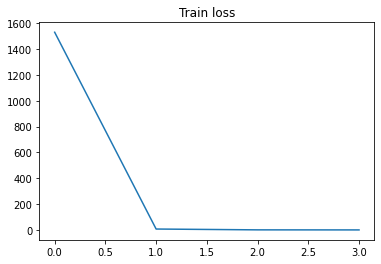

In [142]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.title('Train loss')
plt.show()

In [143]:
import torch

input_data = torch.tensor([4,3,2,0,1])
sorted, indexes = torch.sort(input_data)
print(indexes)

formatted_output = [0 for i in range(5)]
k = 0
for i in indexes:
  formatted_output[k] = int(input_data[i])
  k +=1
print(formatted_output)

tensor([3, 4, 2, 1, 0])
[0, 1, 2, 3, 4]


In [144]:
preds = predict(val_loader, pointer_modified)

softmax = nn.Softmax(dim=1)

def use_indexes_to_build_sorted_array(input_data, indexes):
  formatted_output = [0 for i in range(seq_len)]
  k = 0
  for i in indexes:
    formatted_output[k] = int(input_data[i])
    k +=1
  return formatted_output

C:\Users\Felipe\AppData\Local\Temp\ipykernel_13800\1260709367.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  query = torch.bmm(ref, F.softmax(logits).unsqueeze(2)).squeeze(2)


In [145]:
input_batch = []

it = iter(preds)
input_data, pred = next(it)

In [146]:
input_data

tensor([[0, 3, 8, 6, 2, 5, 9, 1, 7, 4],
        [1, 6, 2, 7, 8, 4, 5, 0, 9, 3]])

In [147]:
pred

[(tensor([[ 5.4544, -8.4155, -8.3221, -8.9122, -8.4207, -8.5722, -8.0611, -4.1618,
           -7.5814, -8.7227],
          [-2.2809, -8.4416, -8.0190, -7.1461, -8.3645, -8.6116, -8.1256,  7.4932,
           -7.1333, -8.7221]], grad_fn=<MulBackward0>),
  tensor([0, 7])),
 (tensor([[-5.3202, -8.8189, -8.8470, -9.7236, -5.7741, -8.9641, -8.3061,  4.8528,
           -8.8376, -9.4387],
          [ 4.4154, -9.5376, -4.8408, -8.6725, -9.0345, -9.3780, -8.4366, -7.9191,
           -7.9701, -9.2715]], grad_fn=<MulBackward0>),
  tensor([7, 0])),
 (tensor([[-9.8789, -4.2134, -9.2871, -9.8948,  5.3139, -9.4023, -9.4531, -6.2067,
           -9.8851, -9.5018],
          [-6.1791, -9.8752,  5.3838, -9.8807, -9.2735, -9.4078, -9.4219, -9.9171,
           -9.6651, -4.5109]], grad_fn=<MulBackward0>),
  tensor([4, 2])),
 (tensor([[-9.6209,  5.0409, -9.0872, -9.8144, -5.5402, -9.2922, -9.3815, -8.5963,
           -9.8873, -6.4724],
          [-8.1971, -9.8122, -5.4404, -9.8265, -9.0076, -5.1082, -9.3415, 

In [148]:
input_batch.append(input_data[0])
input_batch.append(input_data[1])

true_array_indexes = torch.zeros(batch_size, seq_len, dtype=torch.long)
pred_array_indexes = torch.zeros(batch_size, seq_len, dtype=torch.long)

In [149]:
k = 0
for logits, true in pred:
  # print('True:')
  # print(true)

  # (batch_size is 2)
  true_array_indexes[0][k] = true[0]
  true_array_indexes[1][k] = true[1]

  # print('Predicted it must be in position: ')
  argmax_idx = torch.argmax(softmax(logits), dim=1)
  pred_array_indexes[0][k] = argmax_idx[0]
  pred_array_indexes[1][k] = argmax_idx[1]
  k += 1

pred_array_formatted = []
for i in range(batch_size):
  pred_array_formatted.append(use_indexes_to_build_sorted_array(input_batch[i], pred_array_indexes[i]))

true_array_formatted = []
for i in range(batch_size):
  true_array_formatted.append(use_indexes_to_build_sorted_array(input_batch[i], true_array_indexes[i]))

# this commentted code is just to ensure that true_array_indexes is being interpreted correctly,
# which means the below true_array must be equal to true_array_indexes

true_array = []
for i in range(batch_size):
  true_array.append(torch.sort(input_batch[i])[1])
print('true array')
print(true_array)

true array
[tensor([0, 7, 4, 1, 9, 5, 3, 8, 2, 6]), tensor([7, 0, 2, 9, 5, 6, 1, 3, 4, 8])]


In [150]:
print('-----------')
print('input_batch')
print(np.array(input_batch))
print()

print('true indexes')
print(true_array_indexes.numpy())
print()

print('true formatted')
print(np.array(true_array_formatted))
print()

print('pred indexes')
print(pred_array_indexes.numpy())
print()

print('pred formatted')
print(np.array(pred_array_formatted))
print()

# input_batch = []

-----------
input_batch
[tensor([0, 3, 8, 6, 2, 5, 9, 1, 7, 4])
 tensor([1, 6, 2, 7, 8, 4, 5, 0, 9, 3])]

true indexes
[[0 7 4 1 9 0 0 0 0 0]
 [7 0 2 9 5 0 0 0 0 0]]

true formatted
[[0 1 2 3 4 0 0 0 0 0]
 [0 1 2 3 4 1 1 1 1 1]]

pred indexes
[[0 7 4 1 9 0 0 0 0 0]
 [7 0 2 9 5 0 0 0 0 0]]

pred formatted
[[0 1 2 3 4 0 0 0 0 0]
 [0 1 2 3 4 1 1 1 1 1]]



C:\Users\Felipe\AppData\Local\Temp\ipykernel_13800\1064179271.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(np.array(input_batch))
C:\Users\Felipe\AppData\Local\Temp\ipykernel_13800\1064179271.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(input_batch))
